<p style="font-size: 45px; text-align: center;"><b>Machine Learning in Finance II - final project</b></p>
<p style="font-size: 35px; text-align: center;"><b>Forecasting delays in delivery time - Brazilian E-commerce</b></p>
<p style="font-size: 20px; text-align: center;"><b>LightGBM - choosing the best model</b></p>

Author: Jakub Pyszniak

Notebook 4

# Analysis overview

> **In this section we will choose the best LightGBM (regressor) model to predict order delays**

> **We perform the necessary Cross-Validation**

# Libraries

In [13]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import make_scorer
from sklearn.feature_selection import SelectFromModel
from scipy import stats
import math
import time
from scipy.stats import randint, uniform, loguniform
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error

# Visual set-up
pd.set_option("display.max_columns", 60)

# LightGBM
import lightgbm as lgb
from lightgbm import LGBMRegressor

# Loading data & choosing the best features

We can use the feature ranking from earlier to limit our feature ("X") set size from 30+ to 10 or 15 best

In [2]:
# These data will be used for CV and choosing the best models
df_train = pd.read_csv("4.train_and_test/df_train.csv")

# We will use this set to test the forecasting power of our best models (final comparisons)
df_test = pd.read_csv("4.train_and_test/df_test.csv")

# Our feature ranking dataset
fr = pd.read_excel("3.feature_ranking/feature_ranking.xlsx")

In [3]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73180 entries, 0 to 73179
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   delay_days                     73180 non-null  float64
 1   order_item_id                  73180 non-null  int64  
 2   total_price                    73180 non-null  float64
 3   total_freight                  73180 non-null  float64
 4   order_value_check              73180 non-null  float64
 5   is_payment_sequential_1        73180 non-null  int64  
 6   payment_type_boleto            73180 non-null  int64  
 7   payment_type_credit_card       73180 non-null  int64  
 8   payment_type_debit_card        73180 non-null  int64  
 9   payment_type_voucher           73180 non-null  int64  
 10  installments_boleto            73180 non-null  int64  
 11  installments_credit_card       73180 non-null  int64  
 12  installments_debit_card        73180 non-null 

,delay_days,order_item_id,total_price,total_freight,order_value_check,is_payment_sequential_1,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,installments_boleto,installments_credit_card,installments_debit_card,installments_voucher,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_state,customer_state,cust_sell_same_state,customer_lat,customer_lng,seller_lat,seller_lng,cust_sell_distance_km,order_purchase_month,order_delivery_month,order_purchase_dow,order_delivery_dow,order_estimate_dow
0,-21.0,1,19.99,14.10,34.09,1,0,1,0,0,0,1,0,0,48.0,575.0,1,100.0,20.0,15.0,15.0,43,21,18,0,-22.761992,-43.450873,-23.665703,-46.518082,329.149657,6,6,5,0,0
1,-4.0,1,72.90,19.70,92.60,1,0,1,0,0,0,1,0,0,37.0,360.0,1,650.0,45.0,15.0,25.0,67,14,25,0,-21.679558,-49.762053,-23.179392,-50.634922,189.372236,8,8,0,3,0
2,-38.0,1,50.90,15.57,66.47,1,0,1,0,0,0,1,0,0,60.0,473.0,1,600.0,30.0,4.0,20.0,39,21,18,0,-22.449744,-43.474330,-21.766477,-48.831547,557.068979,2,2,3,4,0
3,-8.0,1,199.90,14.23,214.13,1,0,1,0,0,0,5,0,0,60.0,233.0,1,2600.0,41.0,8.0,36.0,7,21,25,1,-23.640572,-46.570773,-22.716839,-47.657366,151.282904,6,6,0,2,3
4,-12.0,2,44.00,35.26,79.26,1,0,1,0,0,0,7,0,0,58.0,1623.0,1,200.0,26.0,10.0,22.0,7,5,18,0,-22.983577,-43.220723,-16.692331,-49.268016,942.794225,3,3,4,2,0


In [4]:
df_test.info()
df_test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18295 entries, 0 to 18294
Data columns (total 35 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   delay_days                     18295 non-null  float64
 1   order_item_id                  18295 non-null  int64  
 2   total_price                    18295 non-null  float64
 3   total_freight                  18295 non-null  float64
 4   order_value_check              18295 non-null  float64
 5   is_payment_sequential_1        18295 non-null  int64  
 6   payment_type_boleto            18295 non-null  int64  
 7   payment_type_credit_card       18295 non-null  int64  
 8   payment_type_debit_card        18295 non-null  int64  
 9   payment_type_voucher           18295 non-null  int64  
 10  installments_boleto            18295 non-null  int64  
 11  installments_credit_card       18295 non-null  int64  
 12  installments_debit_card        18295 non-null 

,delay_days,order_item_id,total_price,total_freight,order_value_check,is_payment_sequential_1,payment_type_boleto,payment_type_credit_card,payment_type_debit_card,payment_type_voucher,installments_boleto,installments_credit_card,installments_debit_card,installments_voucher,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,seller_state,customer_state,cust_sell_same_state,customer_lat,customer_lng,seller_lat,seller_lng,cust_sell_distance_km,order_purchase_month,order_delivery_month,order_purchase_dow,order_delivery_dow,order_estimate_dow
0,-15.0,1,108.0,16.52,124.52,1,0,1,0,0,0,1,0,0,58.0,3006.0,2,1000.0,53.0,8.0,18.0,72,15,10,0,-21.248980,-44.998179,-22.874599,-43.477731,239.212282,2,2,5,3,4
1,-2.0,1,78.0,7.80,85.80,1,0,1,0,0,0,2,0,0,59.0,319.0,4,250.0,16.0,2.0,20.0,72,21,25,1,-23.657047,-46.774874,-23.651115,-46.755211,2.108617,11,11,4,1,3
2,-19.0,1,199.9,15.15,215.05,1,0,1,0,0,0,5,0,0,55.0,623.0,1,337.0,16.0,13.0,13.0,72,21,18,0,-22.704280,-43.571287,-22.828655,-47.267296,379.200398,6,6,3,2,0
3,-17.0,1,69.0,19.45,88.45,1,0,1,0,0,0,6,0,0,51.0,324.0,1,900.0,42.0,8.0,37.0,7,21,18,0,-22.747569,-43.488349,-21.766477,-48.831547,560.549267,6,6,3,0,3
4,-5.0,1,44.9,9.42,54.32,1,1,0,0,0,1,0,0,0,51.0,1118.0,5,400.0,18.0,8.0,14.0,49,21,25,1,-23.663579,-46.617176,-23.198860,-47.293346,86.193580,3,3,3,3,1


In [5]:
fr.rename(columns={"Unnamed: 0": "feature"}, inplace=True)

fr = fr.sort_values(by=["boruta_rank","mi_score"], ascending=[True, False])

fr.info()
fr.head(40)

<class 'pandas.core.frame.DataFrame'>
Index: 34 entries, 2 to 11
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   feature      34 non-null     object 
 1   mi_score     34 non-null     float64
 2   boruta_rank  34 non-null     int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 1.1+ KB


,feature,mi_score,boruta_rank
2,total_freight,0.071483,1
29,order_purchase_month,0.067143,1
30,order_delivery_month,0.063950,1
27,seller_lng,0.057679,1
28,cust_sell_distance_km,0.052569,1
24,customer_lat,0.046624,1
25,customer_lng,0.044898,1
23,cust_sell_same_state,0.043066,1
21,seller_state,0.020188,1
13,product_name_length,0.003299,1


In [6]:
fr = fr.set_index("feature")

We will create arrays with the best features so that we can pick them later from our dataframes

In [7]:
br10_feat = fr.iloc[0:10].index.tolist()
print("10 best:\n", br10_feat)

br15_feat = fr.iloc[0:15].index.tolist()
print("15 best:\n", br15_feat)

br20_feat = fr.iloc[0:20].index.tolist()
print("20 best:\n", br20_feat)

br25_feat = fr.iloc[0:25].index.tolist()
print("25 best:\n", br25_feat)

br30_feat = fr.iloc[0:30].index.tolist()
print("30 best:\n", br30_feat)

10 best:
 ['total_freight', 'order_purchase_month', 'order_delivery_month', 'seller_lng', 'cust_sell_distance_km', 'customer_lat', 'customer_lng', 'cust_sell_same_state', 'seller_state', 'product_name_length']
15 best:
 ['total_freight', 'order_purchase_month', 'order_delivery_month', 'seller_lng', 'cust_sell_distance_km', 'customer_lat', 'customer_lng', 'cust_sell_same_state', 'seller_state', 'product_name_length', 'product_width_cm', 'order_estimate_dow', 'product_weight_g', 'seller_lat', 'product_height_cm']
20 best:
 ['total_freight', 'order_purchase_month', 'order_delivery_month', 'seller_lng', 'cust_sell_distance_km', 'customer_lat', 'customer_lng', 'cust_sell_same_state', 'seller_state', 'product_name_length', 'product_width_cm', 'order_estimate_dow', 'product_weight_g', 'seller_lat', 'product_height_cm', 'order_value_check', 'customer_state', 'product_description_length', 'total_price', 'order_delivery_dow']
25 best:
 ['total_freight', 'order_purchase_month', 'order_delivery_mo

## X and y test/train

In [8]:
# build X / y splits using only the selected features

X10_train = df_train.loc[:, br10_feat].copy()
X15_train = df_train.loc[:, br15_feat].copy()
X20_train = df_train.loc[:, br20_feat].copy()
X25_train = df_train.loc[:, br25_feat].copy()
X30_train = df_train.loc[:, br30_feat].copy()
y_train = df_train.loc[:, "delay_days"].copy()

X10_test  = df_test.loc[:, br10_feat].copy()
X15_test  = df_test.loc[:, br15_feat].copy()
X20_test  = df_test.loc[:, br20_feat].copy()
X25_test  = df_test.loc[:, br25_feat].copy()
X30_test  = df_test.loc[:, br30_feat].copy()
y_test  = df_test.loc[:, "delay_days"].copy()

In [9]:
X10_train.info(), X15_train.info(), X20_train.info(), X25_train.info(), X30_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73180 entries, 0 to 73179
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_freight          73180 non-null  float64
 1   order_purchase_month   73180 non-null  int64  
 2   order_delivery_month   73180 non-null  int64  
 3   seller_lng             73180 non-null  float64
 4   cust_sell_distance_km  73180 non-null  float64
 5   customer_lat           73180 non-null  float64
 6   customer_lng           73180 non-null  float64
 7   cust_sell_same_state   73180 non-null  int64  
 8   seller_state           73180 non-null  int64  
 9   product_name_length    73180 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 5.6 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73180 entries, 0 to 73179
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0  

(None, None, None, None, None)

In [10]:
X10_test.info(), X15_test.info(), X20_test.info(), X25_test.info(), X30_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18295 entries, 0 to 18294
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_freight          18295 non-null  float64
 1   order_purchase_month   18295 non-null  int64  
 2   order_delivery_month   18295 non-null  int64  
 3   seller_lng             18295 non-null  float64
 4   cust_sell_distance_km  18295 non-null  float64
 5   customer_lat           18295 non-null  float64
 6   customer_lng           18295 non-null  float64
 7   cust_sell_same_state   18295 non-null  int64  
 8   seller_state           18295 non-null  int64  
 9   product_name_length    18295 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 1.4 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18295 entries, 0 to 18294
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0  

(None, None, None, None, None)

In [11]:
y_train.info()

<class 'pandas.core.series.Series'>
RangeIndex: 73180 entries, 0 to 73179
Series name: delay_days
Non-Null Count  Dtype  
--------------  -----  
73180 non-null  float64
dtypes: float64(1)
memory usage: 571.8 KB


In [12]:
y_test.info()

<class 'pandas.core.series.Series'>
RangeIndex: 18295 entries, 0 to 18294
Series name: delay_days
Non-Null Count  Dtype  
--------------  -----  
18295 non-null  float64
dtypes: float64(1)
memory usage: 143.1 KB


# Model selection

A standard GridSearchCV might be too taxing for a LightGBM model if we want to try out a variety of hyperparameters. We will use RandomizedSearchCV as a basis.

> Our RandomizedSearchCV set-up

In [20]:
def cv_my_random_lgbm(
    X_train, y_train, X_test, y_test,
    param_distributions=None,
    n_iter=60,
    cv=5,
    random_state=42,
    show_results=False
):
    # ----------------------------
    # 0) Timer
    # ----------------------------
    start = time.perf_counter()

    # ----------------------------
    # 1) CV splitter (shuffled + reproducible)
    # ----------------------------
    cv_split = KFold(n_splits=cv, shuffle=True, random_state=random_state)

    # ----------------------------
    # 2) Base model (silent)
    # ----------------------------
    lgbm = LGBMRegressor(
        boosting_type="gbdt",
        random_state=random_state,
        n_jobs=-1,
        verbose=-1
    )

    # ----------------------------
    # 3) Default search space
    #    - subsample == bagging_fraction
    #    - subsample_freq == bagging_freq
    # ----------------------------
    if param_distributions is None:
        param_distributions = {
            # Trees / learning rate
            "n_estimators": randint(300, 3000),
            "learning_rate": loguniform(0.01, 0.2),

            # Tree structure / capacity
            "num_leaves": randint(16, 256),
            "max_depth": randint(-1, 16),           # -1 = no limit
           # Leaf regularization based on Hessian mass (often robust for regression)
            "min_sum_hessian_in_leaf": loguniform(1e-3, 10.0),

            # Bagging (row sampling) / feature sampling
            "subsample": uniform(0.6, 0.4),         # bagging_fraction in native API
            "subsample_freq": randint(0, 11),       # bagging_freq (0 disables; 1..10 common)
            "colsample_bytree": uniform(0.6, 0.4),  # feature_fraction in native API

            # Regularization
            "reg_alpha": loguniform(1e-8, 10.0),    # L1
            "reg_lambda": loguniform(1e-8, 50.0),   # L2
            "min_split_gain": loguniform(1e-8, 1.0) # gamma-like split penalty
        }

    # ----------------------------
    # 4) Randomized search (silent)
    # ----------------------------
    search = RandomizedSearchCV(
        estimator=lgbm,
        param_distributions=param_distributions,
        n_iter=n_iter,
        scoring="neg_root_mean_squared_error",
        cv=cv_split,
        refit=True,
        return_train_score=True,
        n_jobs=-1,
        random_state=random_state,
        verbose=0
    )

    search.fit(X_train, np.asarray(y_train).ravel())

    best_model = search.best_estimator_

    # ----------------------------
    # 5) Final evaluation on test
    # ----------------------------
    y_pred = best_model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae  = mean_absolute_error(y_test, y_pred)
    r2   = r2_score(y_test, y_pred)

    elapsed_sec = time.perf_counter() - start

    if show_results:
        print("Best params:", search.best_params_)
        print("Best CV RMSE:", -search.best_score_)
        print("TEST RMSE:", rmse)
        print("TEST MAE:", mae)
        print("TEST R²:", r2)
        print(f"Elapsed time: {elapsed_sec:.2f} seconds")

    return {
        "search": search,
        "best_model": best_model,
        "best_cv_rmse": -search.best_score_,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "elapsed_sec": elapsed_sec
    }


**Different variables**

In [21]:
param_distributions = {
            #"n_estimators": randint(100, 700), # in the second stage
            "learning_rate": loguniform(0.01, 0.2),
            "num_leaves": randint(8, 50),
            "max_depth": randint(1, 16),           # -1 = no limit
            "min_sum_hessian_in_leaf": loguniform(1e-3, 10.0), #regularisation
            "subsample": uniform(0.6, 0.4),         # bagging_fraction in native API
            "subsample_freq": randint(0, 11),       # bagging_freq (0 disables; 1..10 common)
            "colsample_bytree": uniform(0.6, 0.4),  # feature_fraction in native API
            "reg_alpha": loguniform(1e-8, 10.0),    # L1
            "reg_lambda": loguniform(1e-8, 50.0),   # L2
        }

lgbm10vars_RS = cv_my_random_lgbm(
    X10_train, y_train, X10_test, y_test,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    random_state=42,
    show_results=True
)

Best params: {'colsample_bytree': np.float64(0.6812244898939077), 'learning_rate': np.float64(0.16853137993978487), 'max_depth': 7, 'min_sum_hessian_in_leaf': np.float64(0.014421346497969485), 'num_leaves': 29, 'reg_alpha': np.float64(0.8398670653892879), 'reg_lambda': np.float64(0.011365569053246658), 'subsample': np.float64(0.7182534743350856), 'subsample_freq': 4}
Best CV RMSE: 7.701524298529636
TEST RMSE: 7.54629110560704
TEST MAE: 5.355234963999354
TEST R²: 0.4687515029087551
Elapsed time: 84.35 seconds


In [23]:
lgbm15vars_RS = cv_my_random_lgbm(
    X15_train, y_train, X15_test, y_test,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    random_state=42,
    show_results=True
)

Best params: {'colsample_bytree': np.float64(0.7245653237565177), 'learning_rate': np.float64(0.18809297639520497), 'max_depth': 5, 'min_sum_hessian_in_leaf': np.float64(0.07883068789768044), 'num_leaves': 33, 'reg_alpha': np.float64(0.07417880061891166), 'reg_lambda': np.float64(0.6702313846810152), 'subsample': np.float64(0.7385217284357604), 'subsample_freq': 4}
Best CV RMSE: 7.6748478556473
TEST RMSE: 7.555070341210847
TEST MAE: 5.342443576957915
TEST R²: 0.4675146917015147
Elapsed time: 95.50 seconds


In [24]:
lgbm20vars_RS = cv_my_random_lgbm(
    X20_train, y_train, X20_test, y_test,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    random_state=42,
    show_results=True
)

Best params: {'colsample_bytree': np.float64(0.6812244898939077), 'learning_rate': np.float64(0.16853137993978487), 'max_depth': 7, 'min_sum_hessian_in_leaf': np.float64(0.014421346497969485), 'num_leaves': 29, 'reg_alpha': np.float64(0.8398670653892879), 'reg_lambda': np.float64(0.011365569053246658), 'subsample': np.float64(0.7182534743350856), 'subsample_freq': 4}
Best CV RMSE: 7.677124751965275
TEST RMSE: 7.643936615110062
TEST MAE: 5.329888586949245
TEST R²: 0.45491433643982926
Elapsed time: 107.22 seconds


> **The last two models show an increase in TEST RMSE - let's stick to lgbm10vars_RS**

## Feature importance

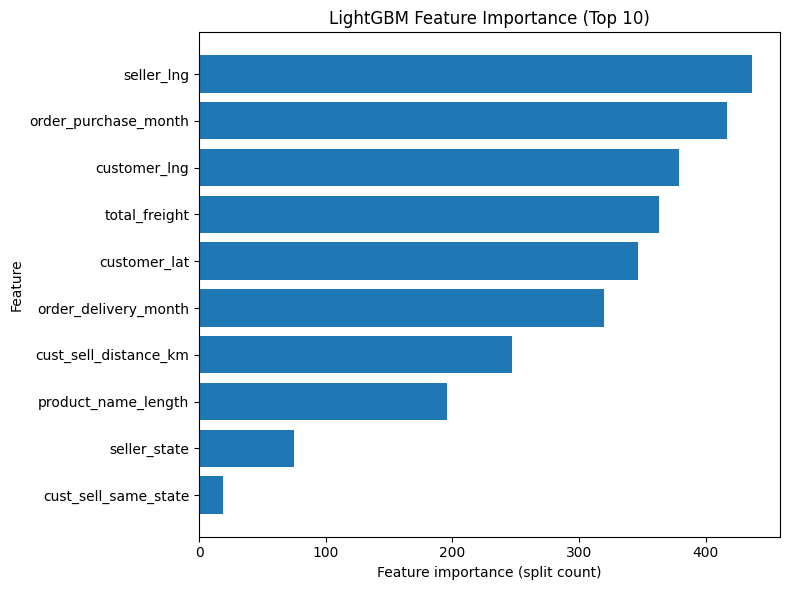

In [25]:
# 1) Grab the fitted best model from the RandomizedSearch run
best_lgbm = lgbm10vars_RS["best_model"]

# 2) Get feature names (works for pandas DataFrame; fallback for numpy)
if hasattr(X10_train, "columns"):
    feature_names = list(X10_train.columns)
else:
    feature_names = [f"feature_{i}" for i in range(best_lgbm.n_features_in_)]

# 3) Pull feature importances from LightGBM (default: split importance)
importances = best_lgbm.feature_importances_

fi = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
      .sort_values("importance", ascending=False)
      .reset_index(drop=True)
)

# 4) Plot (top 25 for readability)
top_n = min(25, len(fi))
fi_top = fi.head(top_n)

plt.figure(figsize=(8, 6))
plt.barh(fi_top["feature"][::-1], fi_top["importance"][::-1])
plt.xlabel("Feature importance (split count)")
plt.ylabel("Feature")
plt.title(f"LightGBM Feature Importance (Top {top_n})")
plt.tight_layout()
plt.show()

# Optional: see the table
# fi.head(25)


We see quite different variables at the top compared to XGBoost's FI.

Let's choose the best 6 and estimate a model with only those features

In [ ]:
# Get top 6 feature names from the importance table you already built (fi)
top6_features = fi.loc[:5, "feature"].tolist()   # fi is already sorted descending
top6_features

# Filter train/test to only those 6 features 
X10_train_top6 = X10_train.loc[:, top6_features].copy()
X10_test_top6  = X10_test.loc[:, top6_features].copy()

X10_train_top6.shape, X10_test_top6.shape

((73180, 6), (18295, 6))

In [27]:
lgbm10_top6vars_RS = cv_my_random_lgbm(
    X10_train_top6, y_train, X10_test_top6, y_test,
    param_distributions=param_distributions,
    n_iter=50,
    cv=5,
    random_state=42,
    show_results=True
)

Best params: {'colsample_bytree': np.float64(0.7529847965068651), 'learning_rate': np.float64(0.19020103466213772), 'max_depth': 9, 'min_sum_hessian_in_leaf': np.float64(0.0015339162591163618), 'num_leaves': 14, 'reg_alpha': np.float64(3.425445902633376e-07), 'reg_lambda': np.float64(4.274973718136613e-08), 'subsample': np.float64(0.9795542149013333), 'subsample_freq': 1}
Best CV RMSE: 7.716575365479011
TEST RMSE: 7.613856823655883
TEST MAE: 5.4444727200277585
TEST R²: 0.4591958483592008
Elapsed time: 121.82 seconds


In [28]:
lgbm10vars_RS["rmse"]

np.float64(7.54629110560704)

> **We didn't get an improvement. Let's stick to lgbm10vars_RS**

## LGB.dataset & Eearly stopping

We can utilise LGBM's handling of categorical features to further tune the model and also look at early stopping and number of boosting rounds

In [31]:
# A quick refresher to see which features supposed to be categorical
# Full derivation and understanding of these variables is presented in Notebooks 1 and 2
X10_train.info() # or test - they have the same features
X10_train.nunique()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73180 entries, 0 to 73179
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   total_freight          73180 non-null  float64
 1   order_purchase_month   73180 non-null  int64  
 2   order_delivery_month   73180 non-null  int64  
 3   seller_lng             73180 non-null  float64
 4   cust_sell_distance_km  73180 non-null  float64
 5   customer_lat           73180 non-null  float64
 6   customer_lng           73180 non-null  float64
 7   cust_sell_same_state   73180 non-null  int64  
 8   seller_state           73180 non-null  int64  
 9   product_name_length    73180 non-null  float64
dtypes: float64(6), int64(4)
memory usage: 5.6 MB


total_freight             6579
order_purchase_month        12
order_delivery_month        12
seller_lng                2043
cust_sell_distance_km    69767
customer_lat             13903
customer_lng             13904
cust_sell_same_state         2
seller_state                22
product_name_length         62
dtype: int64

Best num_boost_round (best_iteration): 717
Best CV RMSE (native lgb.cv): 7.827267431601234


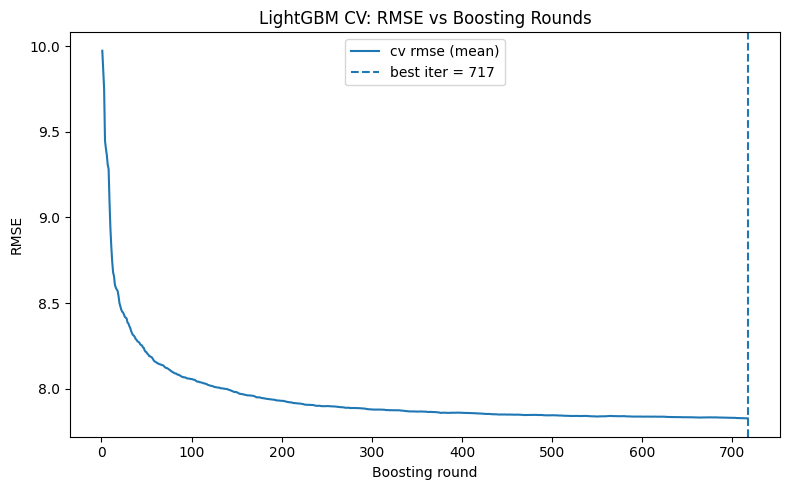

FINAL TEST RMSE: 7.773638064610461


In [34]:
# ============================================================
# 1) Identify categorical features
#    - If X_train is a pandas DataFrame and categorical cols are dtype "category",
#      this auto-detects them.
#    - Otherwise, set cat_cols manually: cat_cols = ["seller_state", "customer_state", ...]
# ============================================================
#cat_cols = list(X_train.select_dtypes(include=["category"]).columns)
cat_cols = ["order_purchase_month", "order_delivery_month", "seller_state"] # easier with our set-up to do it manually

# ============================================================
# 2) Build LightGBM Dataset (native API)
# ============================================================
dtrain = lgb.Dataset(
    X10_train,
    label=np.asarray(y_train).ravel(),
    categorical_feature=cat_cols,   # can be column names (DataFrame) or indices (numpy)
    free_raw_data=False
)

# ============================================================
# 3) Take best params from your RandomizedSearchCV run and make them native-compatible
#    - Remove n_estimators if present (native CV will choose boosting rounds)
#    - Keep "learning_rate", "num_leaves", "max_depth", regularization, bagging, etc.
# ============================================================
best_params = lgbm10vars_RS["search"].best_params_  

params = dict(best_params)
params.pop("n_estimators", None)  # native CV decides num_boost_round - a good precaution, although we didn't include them in our CV

# Add native essentials (silent + metric)
params.update({
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt",
})

# ============================================================
# 4) Native LightGBM CV with early stopping
#    - num_boost_round is the maximum number of boosting iterations
#    - early_stopping_rounds stops when CV score doesn't improve for N rounds
# ============================================================
num_boost_round = 10_000 # we probably won't get there
early_stopping_rounds = 50

cv_results = lgb.cv(
    params=params,
    train_set=dtrain,
    num_boost_round=num_boost_round,
    nfold=5,
    stratified=False,
    shuffle=True,
    seed=42,
    callbacks=[
        lgb.early_stopping(stopping_rounds=early_stopping_rounds, verbose=False),
        lgb.log_evaluation(period=0)  # keeps it quiet
    ],
    return_cvbooster=False
)

# cv_results is a dict of lists; keys usually include: "rmse-mean", " valid rmse-stdv"
rmse_mean = cv_results["valid rmse-mean"]
best_iter = int(np.argmin(rmse_mean) + 1)      # 1-based iteration count
best_cv_rmse = float(np.min(rmse_mean))

print("Best num_boost_round (best_iteration):", best_iter)
print("Best CV RMSE (native lgb.cv):", best_cv_rmse)

# ============================================================
# 5) Plot RMSE vs boosting rounds + vertical line at best iteration
# ============================================================
rounds = np.arange(1, len(rmse_mean) + 1)

plt.figure(figsize=(8, 5))
plt.plot(rounds, rmse_mean, label="cv rmse (mean)")
plt.axvline(best_iter, linestyle="--", label=f"best iter = {best_iter}")
plt.xlabel("Boosting round")
plt.ylabel("RMSE")
plt.title("LightGBM CV: RMSE vs Boosting Rounds")
plt.legend()
plt.tight_layout()
plt.show()

# ============================================================
# 6) Refit final native model using the chosen number of iterations
#    - This gives us a final model trained on ALL training data
# ============================================================
final_lgbm_native = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=best_iter
)

# Predict on test set + compute metrics (mirrors your XGB workflow)
y_pred = final_lgbm_native.predict(X10_test, num_iteration=best_iter)
rmse_test = np.sqrt(np.mean((np.asarray(y_test).ravel() - y_pred) ** 2))
print("FINAL TEST RMSE:", rmse_test)


We can also manually set-up LGBM training to see how test loss changes over boosting rounds

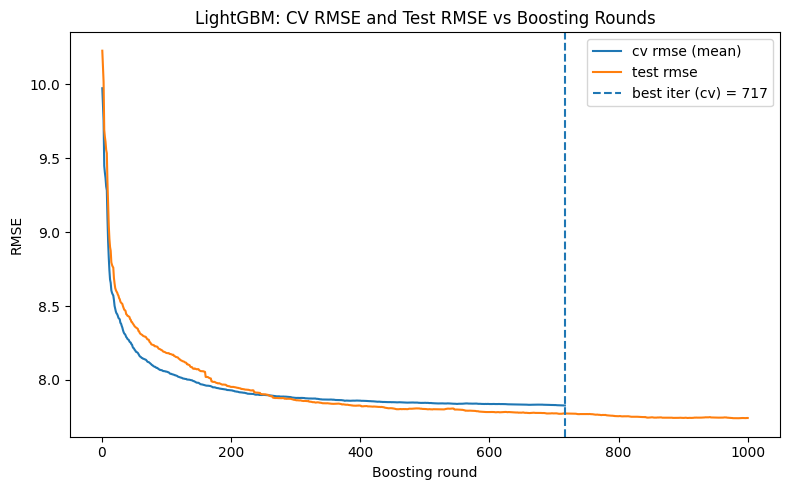

In [37]:
# --- 1) Categorical columns (pandas DataFrame assumed) ---
cat_cols = ["order_purchase_month", "order_delivery_month", "seller_state"] # easier with our set-up to do it manually

# --- 2) Datasets ---
dtrain = lgb.Dataset(
    X10_train, label=np.asarray(y_train).ravel(),
    categorical_feature=cat_cols, free_raw_data=False
)
dtest = lgb.Dataset(
    X10_test, label=np.asarray(y_test).ravel(),
    categorical_feature=cat_cols, reference=dtrain, free_raw_data=False
)

# --- 3) Params (use tuned params; remove n_estimators because we'll control num_boost_round) ---
params = dict(best_params)  # tuned params dict
params.pop("n_estimators", None)
params.update({
    "objective": "regression",
    "metric": "rmse",
    "verbosity": -1,
    "boosting_type": "gbdt",
})

# --- 4) Train and record metrics each iteration ---
evals_result = {}  # LightGBM will fill this with per-iteration metrics

num_boost_round = 1000  # or something > best_iter
booster = lgb.train(
    params=params,
    train_set=dtrain,
    num_boost_round=num_boost_round,
    valid_sets=[dtrain, dtest],
    valid_names=["train", "test"],
    callbacks=[
        lgb.record_evaluation(evals_result),
        lgb.log_evaluation(period=0)  # silent
    ]
)

train_rmse = evals_result["train"]["rmse"]
test_rmse  = evals_result["test"]["rmse"]

# --- 5) Plot CV curve + test curve ---
rmse_cv = cv_results["valid rmse-mean"]  # from your earlier lgb.cv call
rounds_cv = np.arange(1, len(rmse_cv) + 1)
rounds_test = np.arange(1, len(test_rmse) + 1)

best_iter = int(np.argmin(rmse_cv) + 1)

plt.figure(figsize=(8, 5))
plt.plot(rounds_cv, rmse_cv, label="cv rmse (mean)")
plt.plot(rounds_test, test_rmse, label="test rmse")
plt.axvline(best_iter, linestyle="--", label=f"best iter (cv) = {best_iter}")
plt.xlabel("Boosting round")
plt.ylabel("RMSE")
plt.title("LightGBM: CV RMSE and Test RMSE vs Boosting Rounds")
plt.legend()
plt.tight_layout()
plt.show()


In [35]:
rmse_test < lgbm10vars_RS["rmse"]

np.False_

> **Suprisingly this model seems worse. The best model for LightGBM is indeed the first one - lgbm10vars_RS**

> Let's refit the final model

In [ ]:
# ============================================================
# Grab the best hyperparameters from your RandomizedSearchCV run
# ============================================================
best_params = lgbm10vars_RS["search"].best_params_ # using our best params

# Convert numpy scalars -> python scalars (keeps params clean)
best_params_clean = {k: (v.item() if hasattr(v, "item") else v) for k, v in best_params.items()}

# ============================================================
# Refit a fresh LightGBM model on ALL training data
#    (Better than reusing the existing fitted estimator object)
# ============================================================

final_lgbm = LGBMRegressor(
    boosting_type="gbdt",
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    **best_params_clean
)

final_lgbm.fit(X10_train, np.asarray(y_train).ravel())

# ============================================================
# Evaluate on the test set (metrics)
# ============================================================
y_pred = final_lgbm.predict(X10_test)

rmse = float(np.sqrt(mean_squared_error(y_test, y_pred)))
mae  = float(mean_absolute_error(y_test, y_pred))
r2   = float(r2_score(y_test, y_pred))

print("FINAL TEST RMSE:", rmse)
print("FINAL TEST MAE:", mae)
print("FINAL TEST R²:", r2)

FINAL TEST RMSE: 7.54629110560704
FINAL TEST MAE: 5.355234963999354
FINAL TEST R²: 0.4687515029087551


# Saving the best LightGBM model

In [40]:
# ==========================================
# Save the trained model as a pickle file 
# ===========================================

model_path = "5.models/lgbm10vars_final_model.pkl"
with open(model_path, "wb") as f:
    pickle.dump(final_lgbm, f)

print("Saved final model to:", model_path)

Saved final model to: 5.models/lgbm10vars_final_model.pkl


In [41]:
X10_train.to_pickle("6.data_cache/X10_train.pkl")
X10_test.to_pickle("6.data_cache/X10_test.pkl")